## This will be the codebase for the dictionary learning portion

In [111]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage import io
import matplotlib.pyplot as plt
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util

### Read the image

In [54]:
image = io.imread("0.210521.png",as_gray=True)

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [55]:
image.shape

(260, 346)

In [56]:
image.dtype

dtype('float64')

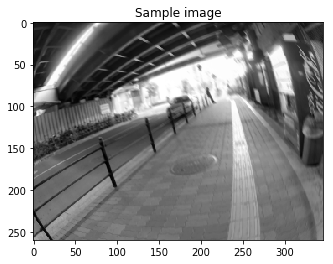

In [57]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [58]:
image_x = ndimage.sobel(image, axis=0)
image_y = ndimage.sobel(image, axis=1)

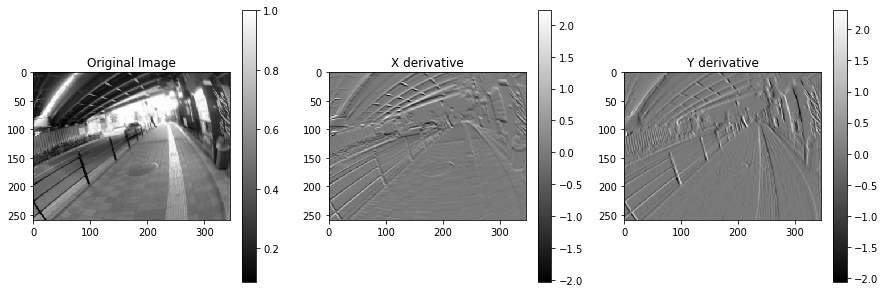

In [59]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
plt.colorbar(p1,ax=ax1)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
plt.colorbar(p2,ax=ax2)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
plt.colorbar(p3,ax=ax3)

plt.show()

In [84]:
patch_size = (7, 7)
patches_x = image_extractor.extract_patches_2d(image_x, patch_size)
patches_y = image_extractor.extract_patches_2d(image_y, patch_size)

In [85]:
patches_x.shape

(86360, 7, 7)

In [86]:
patches_x = patches_x.reshape(patches_x.shape[0], -1)
patches_y = patches_y.reshape(patches_y.shape[0], -1)
patches_x.shape

(86360, 49)

## Create the event histogram

In [63]:
num_time_slices = 5
img_pos = np.zeros((image.shape[0], image.shape[1], num_time_slices), np.float64)
img_neg = np.zeros((image.shape[0], image.shape[1], num_time_slices), np.float64)

In [64]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(row[0]))
        y.append(int(row[1]))
        timestamp.append(float(row[2]))
        pol.append(distutils.util.strtobool(row[3]))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [65]:
total_num_events = len(x)

In [66]:
total_num_events

39969

Convert to numpy arrays

In [67]:
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [68]:
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)
yxt = np.transpose(np.array([y, x, timestamp])) # all events
voxelgrid, edges = np.histogramdd(yxt, bins=bin_edges)

In [69]:
voxelgrid.shape

(260, 346, 5)

In [71]:
# positive events only
idx_pos = pol==0
yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges)

# positive events only
idx_neg = pol!=0
yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges)

In [72]:
voxelgrid_pos.shape

(260, 346, 5)

It is a bit more complicated: I think it is better that the chuncks have equal time span $\Delta t$, rather than equal number of events. See the code from Ex 2 in the course to create the voxel grids.

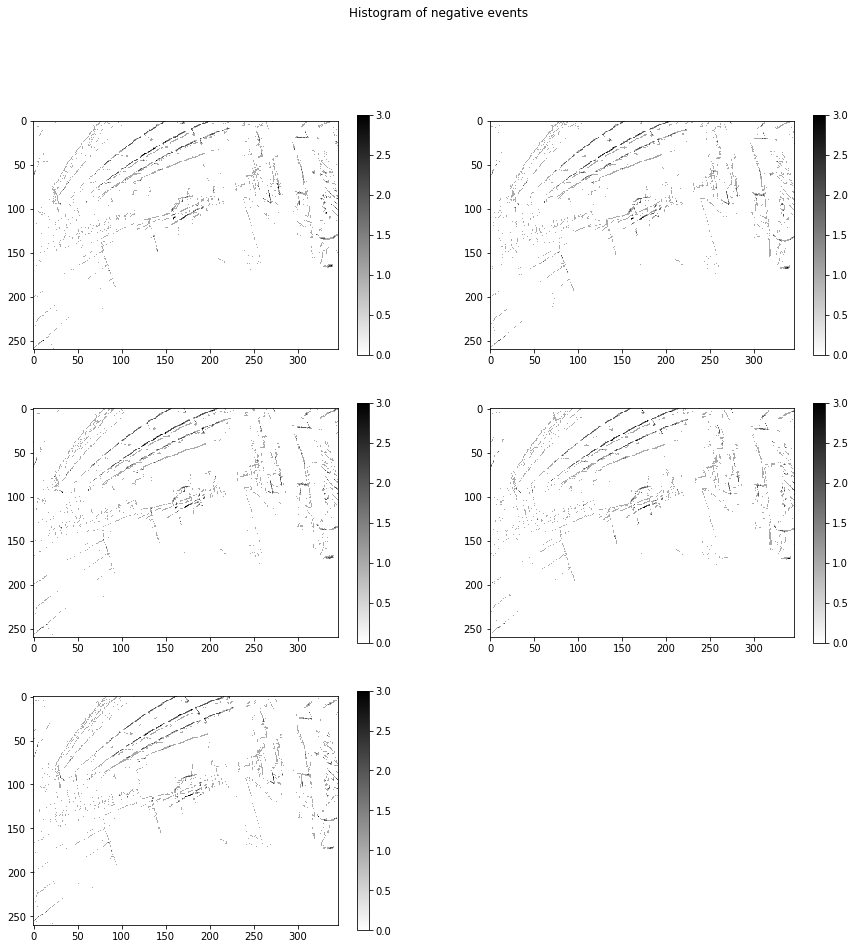

In [73]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histogram of negative events')

for i in range(num_time_slices):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid_neg[:,:,i], cmap='gray_r')
    plt.colorbar()

axs.flat[-1].set_visible(False)

plt.show()

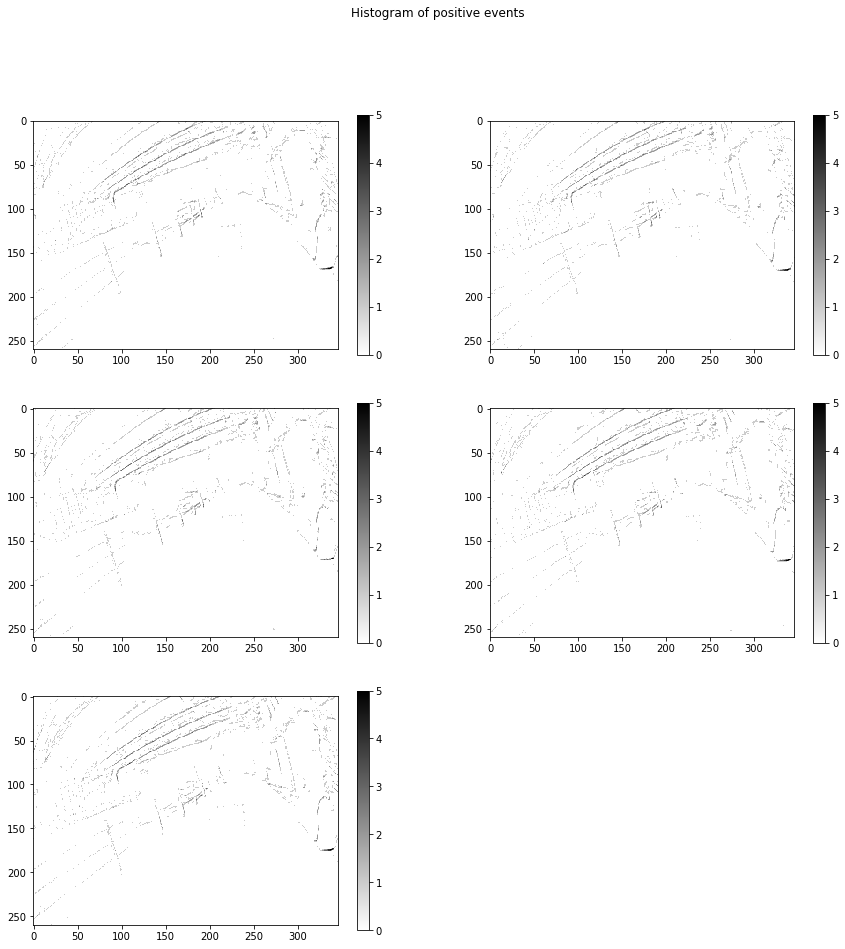

In [74]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Histogram of positive events')

for i in range(num_time_slices):
    plt.sca(axs[int(i/2),i%2])
    plt.imshow(voxelgrid_pos[:,:,i], cmap='gray_r')
    plt.colorbar()
    
axs.flat[-1].set_visible(False)

plt.show()

In [89]:
Ep = image_extractor.extract_patches_2d(voxelgrid_pos, patch_size)
En = image_extractor.extract_patches_2d(voxelgrid_neg, patch_size)

In [90]:
Ep.shape



(86360, 7, 7, 5)

In [91]:
Ep = Ep.reshape(Ep.shape[0], -1)
En = En.reshape(En.shape[0], -1)

In [93]:
Ep.shape

(86360, 245)

In [94]:
Ep[10000]

array([0., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1.,
       1., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 2., 0., 0., 0.,
       0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 2., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0.

In [107]:
y_i = np.hstack([patches_x[0], patches_y[0], Ep[0], En[0]])

In [108]:
y_i.shape

(588,)

In [106]:
49*(1+1+5*2)

588

In [119]:
print('Learning the dictionary...')
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1, n_iter=500)
V = dico.fit(patches_x).components_

Learning the dictionary...


In [120]:
V.shape

(100, 49)

In [115]:
patches_x.shape

(86360, 49)

In [ ]:
(86360, 588)

Visualize the atoms:

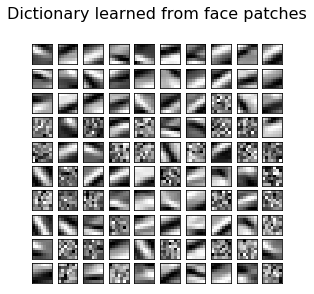

In [121]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned from face patches\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)